# [--- Day 22: Grid Computing ---](http://adventofcode.com/2016/day/22)

You gain access to a massive storage cluster arranged in a grid; each storage node is only connected to the four nodes directly adjacent to it (three if the node is on an edge, two if it's in a corner).

You can directly access data only on node /dev/grid/node-x0-y0, but you can perform some limited actions on the other nodes:

You can get the disk usage of all nodes (via df). The result of doing this is in your puzzle input.
You can instruct a node to move (not copy) all of its data to an adjacent node (if the destination node has enough space to receive the data). The sending node is left empty after this operation.
Nodes are named by their position: the node named node-x10-y10 is adjacent to nodes node-x9-y10, node-x11-y10, node-x10-y9, and node-x10-y11.

Before you begin, you need to understand the arrangement of data on these nodes. Even though you can only move data between directly connected nodes, you're going to need to rearrange a lot of the data to get access to the data you need. Therefore, you need to work out how you might be able to shift data around.

To do this, you'd like to count the number of viable pairs of nodes. A viable pair is any two nodes (A,B), regardless of whether they are directly connected, such that:

- Node A is not empty (its Used is not zero).
- Nodes A and B are not the same node.
- The data on node A (its Used) would fit on node B (its Avail).

**How many viable pairs of nodes are there?**

In [2]:
with open(f'inputs/22.txt') as f:
    data = f.read().strip().split("\n")
data[:10]

['root@ebhq-gridcenter# df -h',
 'Filesystem              Size  Used  Avail  Use%',
 '/dev/grid/node-x0-y0     88T   67T    21T   76%',
 '/dev/grid/node-x0-y1     94T   67T    27T   71%',
 '/dev/grid/node-x0-y2     92T   67T    25T   72%',
 '/dev/grid/node-x0-y3     86T   66T    20T   76%',
 '/dev/grid/node-x0-y4     92T   71T    21T   77%',
 '/dev/grid/node-x0-y5     92T   73T    19T   79%',
 '/dev/grid/node-x0-y6     93T   66T    27T   70%',
 '/dev/grid/node-x0-y7     85T   71T    14T   83%']

First up, I'm going to represent each node as a named tuple:

In [3]:
from collections import namedtuple
node = namedtuple("Node",["x", "y", "size", "used", "avail", "use_pct"])
node(1,2,3,4,5,6)

Node(x=1, y=2, size=3, used=4, avail=5, use_pct=6)

Now to extract the numbers from a given node description:

In [5]:
import re

def make_node(line):
    """takes in a string and returns all the numbers found """
    return node(*[int(i) for i in re.findall('\d+', line)])

print(data[2])
make_node(data[2])

/dev/grid/node-x0-y0     88T   67T    21T   76%


Node(x=0, y=0, size=88, used=67, avail=21, use_pct=76)

So our make node func is working, now to make a list of all nodes:

In [6]:
nodes = [make_node(line) for line in data if line.startswith("/dev/grid/node")]
nodes[:3]

[Node(x=0, y=0, size=88, used=67, avail=21, use_pct=76),
 Node(x=0, y=1, size=94, used=67, avail=27, use_pct=71),
 Node(x=0, y=2, size=92, used=67, avail=25, use_pct=72)]

first up making a function which tells us if two nodes are viable:

In [7]:
def is_viable(a, b):
    """takes in two nodes and returns True if viable, False otherwise"""
    if a.used != 0 and a != b and b.avail >= a.used:
        return True
    return False

Now we compare every node to every other node to make a list of viable nodes. luckily day 21 I already used permutations so that makes it easy to generate pairs of all possible nodes - initially I though of writing my own function for this but permutations is easier/faster.

In [8]:
from itertools import permutations

viable_nodes = []

for a,b in permutations(nodes,2):
    if is_viable(a,b):
        viable_nodes.append((a,b))
        
len(viable_nodes)

872

rewriting the the above `for` loop as a list comprehension for kicks:

In [9]:
viable_nodes = [(a,b) for a,b in permutations(nodes,2) if is_viable(a,b)]
len(viable_nodes)

872

eureka! `872` is the right answer here

# --- Part Two ---

Now that you have a better understanding of the grid, it's time to get to work.

Your goal is to gain access to the data which begins in the node with y=0 and the highest x (that is, the node in the top-right corner).

**What is the fewest number of steps required to move your goal data to node-x0-y0?**

---

first up, whats the node with y=0 and the max x value?

In [8]:
max_x = max([node.x for node in nodes])
[node for node in nodes if node.x == max_x and node.y == 0]

[Node(x=31, y=0, size=89, used=68, avail=21, use_pct=76)]

so there is only one node in the top corner (as there should be else this problem wouldn't compute), so assigining it to a target node variable:

In [10]:
target_node = [node for node in nodes if node.x == max_x and node.y == 0][0]
target_node

Node(x=31, y=0, size=89, used=68, avail=21, use_pct=76)

This looks like a weighted graph problem - we compute all the possible paths for the data to get from our target node to the node at `0,0`, but the problem is its not just a simple graph - the nodes change as the data moves around, so the number of possible moves is very large.

[Dijkstra's_algorithm](https://www.wikiwand.com/en/Dijkstra's_algorithm) is a straight forward way to find the shortest path:

![finding shortest path](https://upload.wikimedia.org/wikipedia/commons/2/23/Dijkstras_progress_animation.gif)

**but after each data move the nodes change - so we need to recalculate the graph!**. So instead of just looking at all possible paths through a graph, we have to search all possible new graphs after each data move. Which will take a looooooong time with the given input size.

so first up, lets eyeball this maze, but in order to do so I need to mark:

- nodes which can't be used, i.e they have too much data to move anywhere
- some kind of color coding for data size

first up, since numpy 2d grids can be a pain, a dict of nodes to make it easy to find a particular node:

In [161]:
nodes_dict = {(n.x,n.y): n for n in nodes}
nodes_dict[0,0]

Node(x=0, y=0, size=88, used=67, avail=21, use_pct=76)

Now to eyeball our nodes:

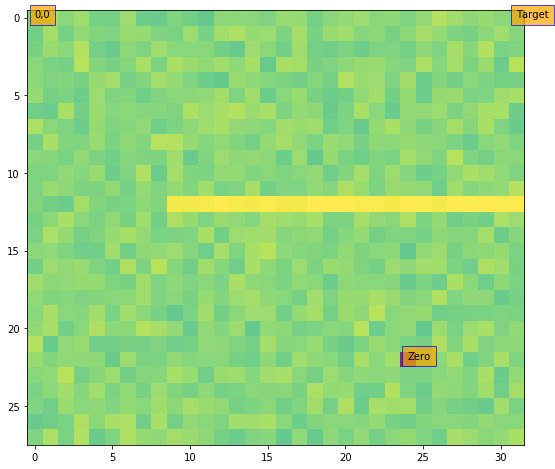

In [195]:
def viz():
    g = [[0 for i in range(max(all_x)+1)] for j in range(max(all_y)+1)]
    
    for n in nodes:
        g[n.y][n.x] = n.used / n.size
        if n.used == 0:
            zero = n
    
    plt.figure(figsize=(12,8))
    plt.imshow(g, alpha=0.8)

    #labelling imp nodes
    box_style = dict(fc="orange", ec="b", lw=1, alpha=0.7, boxstyle="square,pad=0.5")
    plt.annotate("0,0", xy=(0,0), bbox=box_style)
    plt.annotate("Zero", xy=(zero.x,zero.y), bbox=box_style)
    plt.annotate("Target", xy=(31,0), bbox=box_style);

viz()

taking a look at the yellow line:

In [184]:
all_x = [node.x for node in nodes]
all_y = [node.y for node in nodes]

g = [["00/00" for i in range(max(all_x)+1)] for j in range(max(all_y)+1)]

for n in nodes:
    g[n.y][n.x] = str(n.used) + "/" + str(n.avail)

print("used/avail")
for r in g:
    print(" ".join([str(x) for x in r]))

used/avail
67/21 71/15 69/21 71/17 64/24 64/24 73/18 66/28 65/29 69/23 65/26 64/30 72/21 68/20 72/22 68/23 70/18 73/19 67/26 72/22 71/19 70/17 65/20 70/20 64/22 69/19 73/13 73/17 70/20 69/18 68/20 68/21
67/27 72/16 64/24 69/19 64/21 67/23 72/18 73/19 67/23 64/23 69/17 65/24 69/16 73/14 73/19 73/18 69/24 70/15 68/25 72/18 72/17 67/21 68/20 64/24 71/21 73/16 72/19 66/23 64/24 68/20 69/16 69/22
67/25 71/18 67/20 73/13 65/25 65/29 73/21 68/23 71/17 65/20 65/20 65/20 64/25 64/29 71/17 70/21 64/25 73/17 68/26 64/26 69/24 64/27 67/23 64/22 67/26 73/21 70/24 70/15 70/22 72/13 64/23 68/23
66/20 69/25 64/24 73/12 64/21 64/24 71/23 73/15 68/24 73/15 68/17 73/20 73/17 69/20 72/15 64/29 72/15 73/16 67/25 64/22 68/20 73/19 68/17 68/22 67/23 71/14 69/22 73/16 69/24 71/18 64/27 73/12
71/21 67/23 70/23 65/24 73/19 72/16 67/26 70/23 72/16 71/19 64/22 64/27 64/30 72/18 66/19 65/21 69/24 64/25 71/23 67/26 73/13 68/17 70/17 70/24 71/16 66/28 67/22 64/25 70/21 68/24 66/25 65/24
73/19 68/26 68/24 65/28 70/17

from the above analalysis, two things jump out:

- data can't just move to the left, since used data is generally bigger than free space in the nodes
- the yellow line is where nodes have a lot of data - so it can't be moved around
- there is only one node which isn't used - so we need to bring it upwards to the target node

In [182]:
[n for n in nodes if n.used<5]

[Node(x=24, y=22, size=86, used=0, avail=86, use_pct=0)]

so the node at `(24,22)` is empty, so we need to move it next to the target node: